In [1]:
#%pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv("enhanced_anxiety_dataset.csv")
df

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,91,28,1,Yes,Yes,1,No,3,6.0
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,95,17,3,No,No,2,No,7,3.0
10997,29,Male,Nurse,6.7,6.9,159,14,No,No,8,72,16,1,Yes,Yes,2,Yes,7,4.0
10998,53,Other,Artist,5.7,2.7,248,8,No,No,4,112,28,3,Yes,Yes,1,Yes,2,4.0


In [4]:
df['sleep_deficit'] = 7 - df['Sleep Hours']
df['sleep_deficit']

0        1.0
1        0.8
2        2.0
3        1.2
4       -1.2
        ... 
10995    0.9
10996    0.4
10997    0.3
10998    1.3
10999    0.9
Name: sleep_deficit, Length: 11000, dtype: float64

In [5]:
df['awake_hours'] = np.clip(24 - df['Sleep Hours'], 1, None)            
df['awake_hours']

0        18.0
1        17.8
2        19.0
3        18.2
4        15.8
         ... 
10995    17.9
10996    17.4
10997    17.3
10998    18.3
10999    17.9
Name: awake_hours, Length: 11000, dtype: float64

In [6]:
df['caffeine_per_awake_hour'] = df['Caffeine Intake (mg/day)'] / df['awake_hours']
df['caffeine_per_awake_hour']

0        10.055556
1        11.235955
2         6.157895
3        19.780220
4        15.632911
           ...    
10995    31.620112
10996     3.678161
10997     9.190751
10998    13.551913
10999    11.452514
Name: caffeine_per_awake_hour, Length: 11000, dtype: float64

In [7]:
def alcohol_risk_gender_aware(row):
    drinks = row['Alcohol Consumption (drinks/week)']
    g = str(row['Gender']).strip().lower()
    if g == 'male':
        #0 = none, 1–14 = low, 15–28 = moderate, >28 = high
        if drinks == 0: return 'none'
        elif drinks <= 14: return 'low'
        elif drinks <= 28: return 'moderate'
        else: return 'high'
    else:
        if drinks == 0: return 'none'
        elif drinks <= 7: return 'low'
        elif drinks <= 14: return 'moderate'
        else: return 'high'

def alcohol_risk_neutral(drinks_per_week):
    if drinks_per_week == 0: return 'none'
    elif drinks_per_week <= 7: return 'low'
    elif drinks_per_week <= 14: return 'moderate'
    else: return 'high'

df['alcohol_risk'] = df.apply(alcohol_risk_gender_aware, axis=1)
alcohol_map = {'none': 0, 'low': 1, 'moderate': 2, 'high': 3}
df['alcohol_risk_ordinal'] = df['alcohol_risk'].map(alcohol_map)

In [8]:
df['famHist_x_lifeEvent'] = (
        (df['Family History of Anxiety'].str.lower() == 'yes').astype(int) *
        (df['Recent Major Life Event'].str.lower() == 'yes').astype(int)
    )
df['famHist_x_lifeEvent']

0        0
1        0
2        1
3        0
4        0
        ..
10995    0
10996    0
10997    0
10998    0
10999    0
Name: famHist_x_lifeEvent, Length: 11000, dtype: int64

In [9]:
df['alcohol_x_smoking'] = df['Alcohol Consumption (drinks/week)'] * (df['Smoking'].str.lower() == 'yes').astype(int)
df['alcohol_x_smoking']

0        10
1         8
2         0
3         6
4         4
         ..
10995     9
10996    17
10997     0
10998     0
10999     0
Name: alcohol_x_smoking, Length: 11000, dtype: int64

In [10]:
df['is_low_sleep'] = (df['Sleep Hours'] < 7).astype(int)
df['is_high_caffeine'] = (df['Caffeine Intake (mg/day)'] > 400).astype(int)
df['is_high_alcohol']  = (df['alcohol_risk_ordinal'] > 2).astype(int)
df['is_low_activity']  = (df['Physical Activity (hrs/week)'] < 2.5).astype(int)

df['multiple_lifestyle_risks'] = (
        df['is_low_sleep'] + df['is_high_caffeine'] + df['is_high_alcohol'] + df['is_low_activity']
    )
df

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,caffeine_per_awake_hour,alcohol_risk,alcohol_risk_ordinal,famHist_x_lifeEvent,alcohol_x_smoking,is_low_sleep,is_high_caffeine,is_high_alcohol,is_low_activity,multiple_lifestyle_risks
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,...,10.055556,moderate,2,0,10,1,0,0,0,1
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,...,11.235955,moderate,2,0,8,1,0,0,0,1
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,...,6.157895,low,1,1,0,1,0,0,0,1
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,...,19.780220,low,1,0,6,1,0,0,0,1
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,...,15.632911,low,1,0,4,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,...,31.620112,moderate,2,0,9,1,1,0,0,2
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,...,3.678161,high,3,0,17,1,0,1,0,2
10997,29,Male,Nurse,6.7,6.9,159,14,No,No,8,...,9.190751,low,1,0,0,1,0,0,0,1
10998,53,Other,Artist,5.7,2.7,248,8,No,No,4,...,13.551913,moderate,2,0,0,1,0,0,0,1


In [11]:
df[ df['multiple_lifestyle_risks'] == 2]

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,caffeine_per_awake_hour,alcohol_risk,alcohol_risk_ordinal,famHist_x_lifeEvent,alcohol_x_smoking,is_low_sleep,is_high_caffeine,is_high_alcohol,is_low_activity,multiple_lifestyle_risks
8,51,Other,Lawyer,6.6,3.1,587,2,No,No,2,...,33.735632,low,1,0,0,1,1,0,0,2
9,59,Female,Teacher,5.1,4.8,159,15,Yes,No,5,...,8.412698,high,3,0,15,1,0,1,0,2
15,44,Female,Artist,7.7,2.0,164,16,No,Yes,3,...,10.061350,high,3,1,0,0,0,1,1,2
17,61,Other,Musician,6.7,1.0,67,3,Yes,No,8,...,3.872832,low,1,0,3,1,0,0,1,2
20,26,Male,Other,6.9,1.8,95,1,No,Yes,5,...,5.555556,low,1,1,0,1,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,48,Female,Chef,6.8,3.6,307,18,Yes,Yes,7,...,17.848837,high,3,1,18,1,0,1,0,2
10993,43,Female,Artist,7.9,1.8,269,19,No,Yes,2,...,16.708075,high,3,0,0,0,0,1,1,2
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,...,31.620112,moderate,2,0,9,1,1,0,0,2
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,...,3.678161,high,3,0,17,1,0,1,0,2


In [12]:
df['HighAlcohol_Smoking'] = (
    (df['alcohol_risk'] == 'high') &
    (df['Smoking'].str.lower() == 'yes')
).astype(int)

df['ModHighAlcohol_Smoking'] = (
    (df['alcohol_risk'].isin(['moderate', 'high'])) &
    (df['Smoking'].str.lower() == 'yes')
).astype(int)

#correlations
corr_high = df['HighAlcohol_Smoking'].corr(df['Anxiety Level (1-10)'])
corr_mod_high = df['ModHighAlcohol_Smoking'].corr(df['Anxiety Level (1-10)'])

print(f"Correlation (High only)       : {corr_high:.3f}")
print(f"Correlation (Moderate+High)  : {corr_mod_high:.3f}")

Correlation (High only)       : 0.063
Correlation (Moderate+High)  : 0.100


In [13]:
df['Cardio Stress Index'] = (
    df['Heart Rate (bpm)'] * df['Breathing Rate (breaths/min)']
) / df['Sleep Hours']

In [14]:
#create bins and labels
bins = [0, 25, 50, float('inf')]  
labels = ['Young_Adult', 'Middle_Aged', 'Older_Adult']

df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)


age_group_map = {'Young_Adult': 1, 'Middle_Aged': 2, 'Older_Adult': 3}
df['Age_Group_Num'] = df['Age_Group'].map({
    'Young_Adult': 1,
    'Middle_Aged': 2,
    'Older_Adult': 3
}).astype(int)

df['PhysicalActivity_AgeGroup'] = df['Physical Activity (hrs/week)'] * df['Age_Group_Num']

df.head()


,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,is_high_caffeine,is_high_alcohol,is_low_activity,multiple_lifestyle_risks,HighAlcohol_Smoking,ModHighAlcohol_Smoking,Cardio Stress Index,Age_Group,Age_Group_Num,PhysicalActivity_AgeGroup
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,...,0,0,0,1,0,1,266.000000,Middle_Aged,2,5.4
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,...,0,0,0,1,0,1,230.000000,Middle_Aged,2,11.4
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,...,0,0,0,1,0,0,509.600000,Older_Adult,3,11.1
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,...,0,0,0,1,0,0,252.068966,Young_Adult,1,2.8
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,...,0,0,1,1,0,0,227.073171,Middle_Aged,2,4.6


In [15]:
df['Occupation'].unique()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Occupation_encoded'] = le.fit_transform(df['Occupation'])

#occupation, therpay, diet, sweating, medication, dizziness

In [16]:
df['Medication_bin'] = df['Medication'].map({'Yes': 1, 'No': 0})
df['Dizziness_bin'] = df['Dizziness'].map({'Yes': 1, 'No': 0})
df['Family History of Anxiety_bin'] = df['Family History of Anxiety'].map({'Yes': 1, 'No': 0})
df['Recent Major Life Event'] = df['Recent Major Life Event'].map({'Yes': 1, 'No': 0})
df['Smoking_bin'] = df['Smoking'].map({'Yes': 1, 'No': 0})
df['Gender_bin'] = df['Gender'].map({'Male': 1, 'Female': 2, 'Other': 3})
df['therapy_diet_ratio'] = df['Therapy Sessions (per month)'] / (df['Diet Quality (1-10)'] + 1e-6)
df['diet_sweating'] = df['Diet Quality (1-10)'] * df['Sweating Level (1-5)']
df['therapy_sweating'] = df['Therapy Sessions (per month)'] * df['Sweating Level (1-5)']
df['medication_therapy'] = df['Medication_bin'] * df['Therapy Sessions (per month)']


In [17]:
df['med_and_dizzy'] = ((df['Medication_bin'] == 1) & (df['Dizziness_bin'] == 1)).astype(int)
df['high_sweat_low_diet'] = ((df['Sweating Level (1-5)'] >= 4) & (df['Diet Quality (1-10)'] <= 4)).astype(int)
df['therapy_and_dizzy'] = ((df['Therapy Sessions (per month)'] > 0) & (df['Dizziness_bin'] == 1)).astype(int)
df['no_help_high_sweat'] = ((df['Medication_bin'] == 0) &
                             (df['Therapy Sessions (per month)'] == 0) &
                             (df['Sweating Level (1-5)'] >= 4)).astype(int)


In [18]:
df['health_mgmt_score'] = (
    df['Diet Quality (1-10)'] +
    df['Therapy Sessions (per month)'] +
    df['Medication_bin']*2 -
    df['Dizziness_bin']*2 -
    df['Sweating Level (1-5)']
)



In [19]:
columns_to_drop = ['Gender', 'Occupation', 'Smoking', 'Dizziness','Medication', 'Recent Major Life Event', 'Family History of Anxiety', 'Stress Level (1-10)', 'alcohol_risk', 'Age_Group']
df_model = df.drop(columns = columns_to_drop)

In [20]:
df_model.columns.values

array(['Age', 'Sleep Hours', 'Physical Activity (hrs/week)',
       'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)',
       'Heart Rate (bpm)', 'Breathing Rate (breaths/min)',
       'Sweating Level (1-5)', 'Therapy Sessions (per month)',
       'Diet Quality (1-10)', 'Anxiety Level (1-10)', 'sleep_deficit',
       'awake_hours', 'caffeine_per_awake_hour', 'alcohol_risk_ordinal',
       'famHist_x_lifeEvent', 'alcohol_x_smoking', 'is_low_sleep',
       'is_high_caffeine', 'is_high_alcohol', 'is_low_activity',
       'multiple_lifestyle_risks', 'HighAlcohol_Smoking',
       'ModHighAlcohol_Smoking', 'Cardio Stress Index', 'Age_Group_Num',
       'PhysicalActivity_AgeGroup', 'Occupation_encoded',
       'Medication_bin', 'Dizziness_bin', 'Family History of Anxiety_bin',
       'Smoking_bin', 'Gender_bin', 'therapy_diet_ratio', 'diet_sweating',
       'therapy_sweating', 'medication_therapy', 'med_and_dizzy',
       'high_sweat_low_diet', 'therapy_and_dizzy', 'no_help_high

In [21]:
df_model

,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),Diet Quality (1-10),...,Gender_bin,therapy_diet_ratio,diet_sweating,therapy_sweating,medication_therapy,med_and_dizzy,high_sweat_low_diet,therapy_and_dizzy,no_help_high_sweat,health_mgmt_score
0,29,6.0,2.7,181,10,114,14,4,3,7,...,2,0.428571,28,12,3,0,0,0,0,8
1,46,6.2,5.7,200,8,62,23,2,2,8,...,3,0.250000,16,4,0,0,0,1,0,6
2,64,5.0,3.7,117,4,91,28,3,1,1,...,1,0.999999,3,3,0,0,0,0,0,-1
3,20,5.8,2.8,360,6,86,17,3,0,1,...,2,0.000000,3,0,0,0,0,0,0,-2
4,49,8.2,2.3,247,4,98,19,4,1,3,...,2,0.333333,12,4,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,6.1,3.1,566,9,91,28,1,1,3,...,2,0.333333,3,1,1,1,0,1,0,3
10996,50,6.6,3.6,64,17,95,17,3,2,7,...,3,0.285714,21,6,0,0,0,0,0,6
10997,29,6.7,6.9,159,14,72,16,1,2,7,...,1,0.285714,7,2,2,1,0,1,0,8
10998,53,5.7,2.7,248,8,112,28,3,1,2,...,3,0.500000,6,3,1,1,0,1,0,0


In [22]:
target = 'Anxiety Level (1-10)'
X = df_model.drop(columns=[target])
y = df_model[target]

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

#Predictions
y_pred_rf = rf.predict(X_test)

#Evaluate
from sklearn.metrics import mean_squared_error, r2_score
mse  = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print("Random Forest RMSE:", rmse)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 1.3949865292061665
Random Forest R2: 0.5772173374762908


In [25]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

#Predictions
y_pred_xgb = xgb.predict(X_test)

mse  = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print("XGBoost RMSE:", rmse)
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))


XGBoost RMSE: 1.4111241061789497
XGBoost R2: 0.5673790330149524


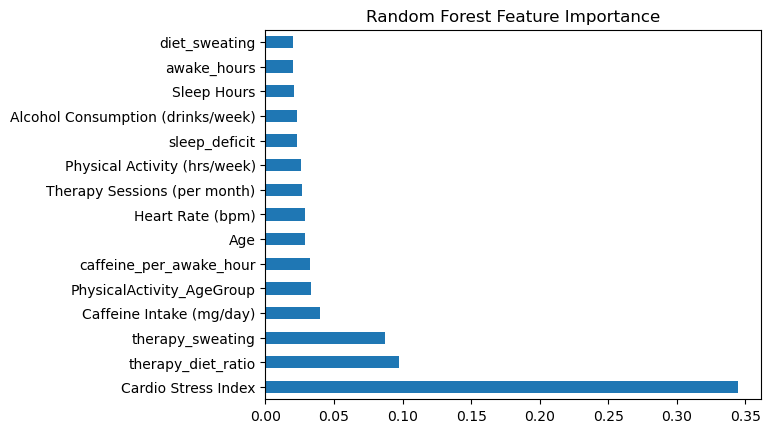

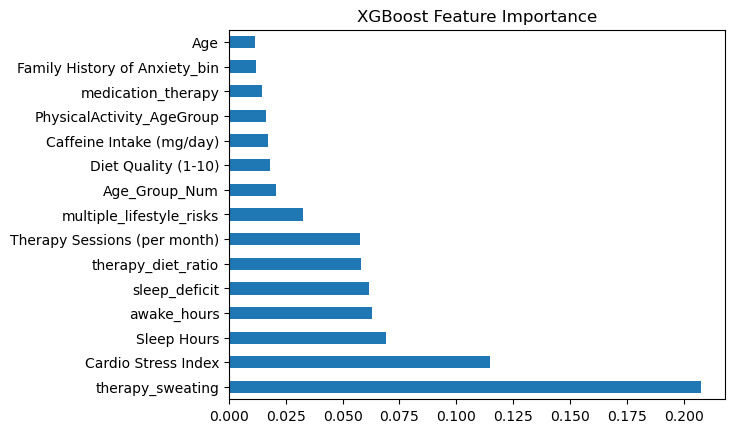

In [26]:
import matplotlib.pyplot as plt

#Random Forest
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.show()

#XGBoost
xgb_feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
xgb_feat_importances.nlargest(15).plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.show()


In [27]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],  
    'max_depth': [None, 3, 5, 7, 10]       
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,               
    scoring='neg_root_mean_squared_error',
     #use all CPU cores
    n_jobs=-1,          
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

#evaluate on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................max_depth=None, n_estimators=100; total time=   7.3s
[CV] END ...................max_depth=None, n_estimators=100; total time=   7.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   7.4s
[CV] END ...................max_depth=None, n_estimators=100; total time=   7.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   7.6s
[CV] END ...................max_depth=None, n_estimators=200; total time=  14.6s
[CV] END ...................max_depth=None, n_estimators=200; total time=  14.7s
[CV] END ...................max_depth=None, n_estimators=200; total time=  15.0s
[CV] END ...................max_depth=None, n_estimators=200; total time=  14.3s
[CV] END ...................max_depth=None, n_estimators=200; total time=  14.9s
[CV] END ...................max_depth=None, n_estimators=300; total time=  21.8s
[CV] END ...................max_depth=None, n_e

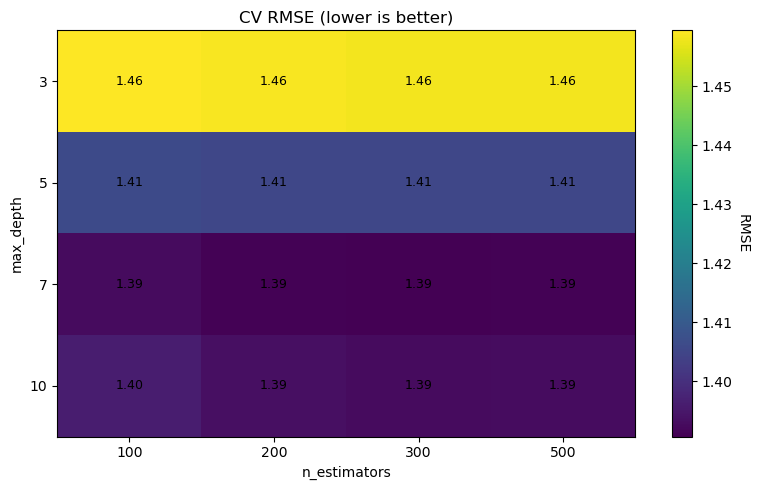

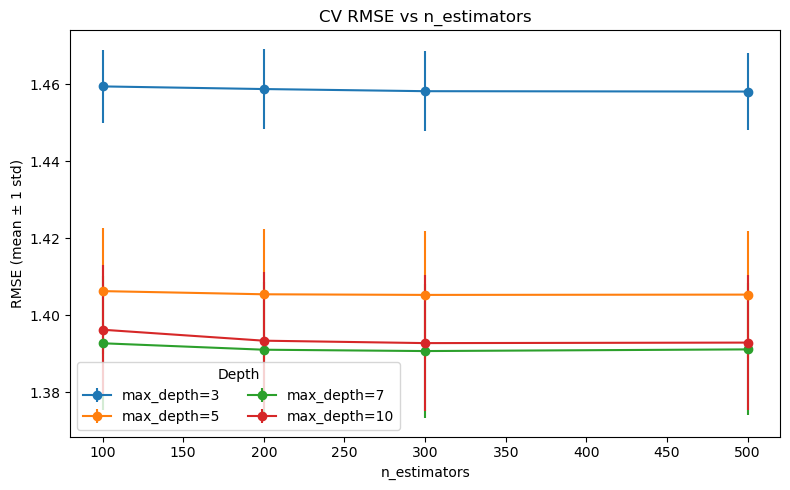

Best parameters: {'max_depth': 7, 'n_estimators': 300}
Best CV RMSE   : 1.3906457502233807


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#pull CV results into a DataFrame
cv = pd.DataFrame(grid_search.cv_results_)

#convert negative RMSE to RMSE
cv['rmse'] = -cv['mean_test_score']
cv['rmse_std'] = cv['std_test_score']

#keep only the params we tuned
cv_small = cv[['param_n_estimators', 'param_max_depth', 'rmse', 'rmse_std']].copy()
cv_small['param_n_estimators'] = cv_small['param_n_estimators'].astype(int)
# max_depth can be None; leave as is

#heatmap of RMSE for depth and estimators
#make a pivot table 
pivot = cv_small.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='rmse'
).sort_index()

plt.figure(figsize=(8, 5))
im = plt.imshow(pivot.values, aspect='auto')
plt.title('CV RMSE (lower is better)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

#tick labels
plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns.tolist(), rotation=0)
#for max_depth, show "None" for NaN if present
row_labels = []
for idx in pivot.index.tolist():
    row_labels.append('None' if (idx is None or (isinstance(idx, float) and np.isnan(idx))) else str(idx))
plt.yticks(ticks=np.arange(pivot.shape[0]), labels=row_labels)

#colorbar + annotate cells
cbar = plt.colorbar(im)
cbar.set_label('RMSE', rotation=270, labelpad=12)

for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

#line plot
plt.figure(figsize=(8, 5))

#for each max_depth, plot rmse across n_estimators with error bars
for depth, grp in cv_small.groupby('param_max_depth'):
    # Sort by n_estimators for a clean line
    grp = grp.sort_values('param_n_estimators')
    label = 'None' if (depth is None or (isinstance(depth, float) and np.isnan(depth))) else f"{depth}"
    plt.errorbar(grp['param_n_estimators'], grp['rmse'], yerr=grp['rmse_std'], marker='o', label=f"max_depth={label}")

plt.title('CV RMSE vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE (mean ± 1 std)')
plt.legend(title='Depth', ncol=2)
plt.tight_layout()
plt.show()

#best params and score
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE   :", -grid_search.best_score_)


In [29]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_params = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5,
                          scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train, y_train)

ridge_best = ridge_grid.best_estimator_
ridge_pred = ridge_best.predict(X_test)

print("Ridge Best Alpha:", ridge_grid.best_params_)
mse  = mean_squared_error(y_test, ridge_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, ridge_pred)

print("Ridge Test RMSE:", rmse)
print("Ridge Test R2:", r2)


Ridge Best Alpha: {'ridge__alpha': 0.1}
Ridge Test RMSE: 1.4973534518482319
Ridge Test R2: 0.5128913990917277


In [30]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

lasso_params = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5,
                          scoring='neg_root_mean_squared_error')
lasso_grid.fit(X_train, y_train)

lasso_best = lasso_grid.best_estimator_
lasso_pred = lasso_best.predict(X_test)

print("\nLasso Best Alpha:", lasso_grid.best_params_)
mse  = mean_squared_error(y_test, lasso_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, lasso_pred)

print("Lasso Test RMSE:", rmse)
print("Lasso Test R2:", r2)



Lasso Best Alpha: {'lasso__alpha': 0.001}
Lasso Test RMSE: 1.4964586551815588
Lasso Test R2: 0.5134734031858434


In [31]:
feature_names = X.columns
#extract coefficients from the best model in the pipeline
lasso_coefs = lasso_best.named_steps['lasso'].coef_

#count non-zero coefficients
non_zero_count = np.sum(lasso_coefs != 0)
zero_count = np.sum(lasso_coefs == 0)

print(f"Total features: {len(lasso_coefs)}")
print(f"Non-zero coefficients: {non_zero_count}")
print(f"Zeroed-out coefficients: {zero_count}")

#show the non-zero ones in a DataFrame
lasso_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefs
})
lasso_coef_df = lasso_coef_df[lasso_coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

print("\nTop features kept by Lasso:")
print(lasso_coef_df)


Total features: 41
Non-zero coefficients: 37
Zeroed-out coefficients: 4

Top features kept by Lasso:
                              Feature   Coefficient
3            Caffeine Intake (mg/day)  2.196512e+00
23                Cardio Stress Index  9.521867e-01
34                   therapy_sweating  3.459356e-01
8        Therapy Sessions (per month)  2.417568e-01
32                 therapy_diet_ratio  1.411791e-01
25          PhysicalActivity_AgeGroup  1.304116e-01
19                    is_low_activity  6.957445e-02
15                  alcohol_x_smoking  6.105644e-02
13               alcohol_risk_ordinal  5.336360e-02
14                famHist_x_lifeEvent  4.780882e-02
36                      med_and_dizzy  4.599345e-02
17                   is_high_caffeine  4.552826e-02
28                      Dizziness_bin  3.450268e-02
4   Alcohol Consumption (drinks/week)  3.437147e-02
35                 medication_therapy  2.748378e-02
9                 Diet Quality (1-10)  2.393820e-02
7              

In [32]:
removed_features = feature_names[lasso_coefs == 0]
print("Features removed by Lasso:", removed_features.tolist())


Features removed by Lasso: ['Sleep Hours', 'multiple_lifestyle_risks', 'Occupation_encoded', 'health_mgmt_score']


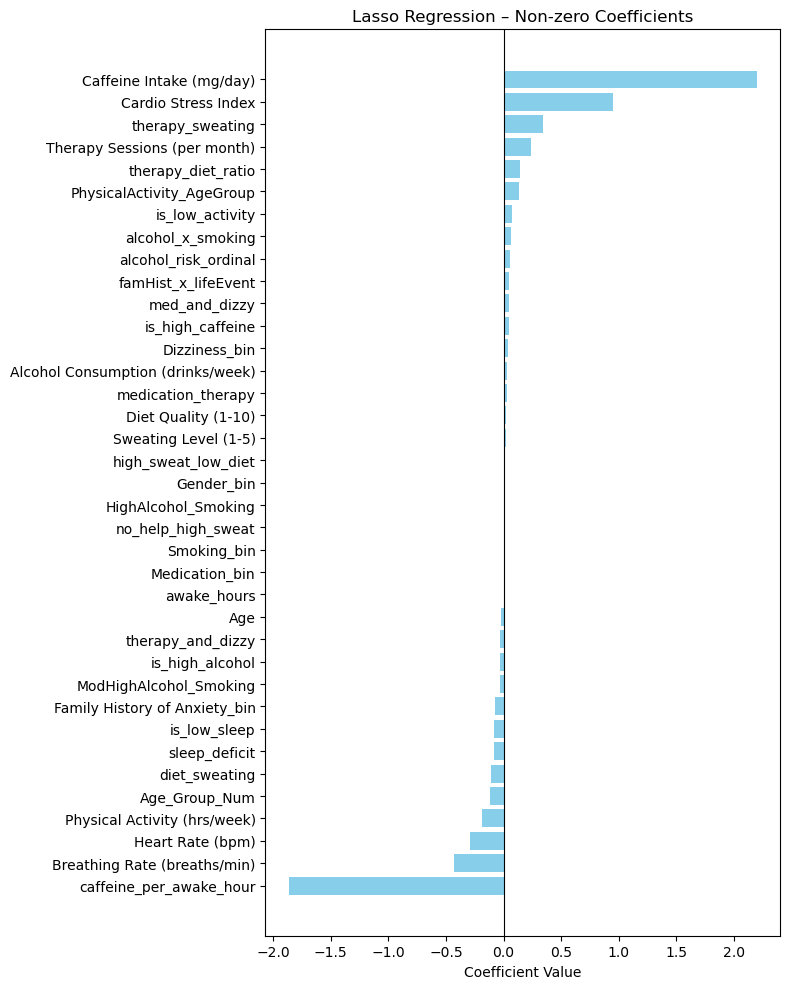

In [33]:
#create DataFrame of non-zero coefficients
lasso_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefs
})
lasso_coef_df = lasso_coef_df[lasso_coef_df['Coefficient'] != 0]  
lasso_coef_df = lasso_coef_df.sort_values(by='Coefficient', ascending=True)  

#plot
plt.figure(figsize=(8, 10))
plt.barh(lasso_coef_df['Feature'], lasso_coef_df['Coefficient'], color='skyblue')
plt.axvline(x=0, color='black', linewidth=0.8)  
plt.xlabel("Coefficient Value")
plt.title("Lasso Regression – Non-zero Coefficients")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 81 candidates, totalling 405 fits
GBR Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.6}
GBR Best CV RMSE: 1.4073699870206131
GBR Test RMSE: 1.3994511303361465
GBR Test R2  : 0.5745068073906736


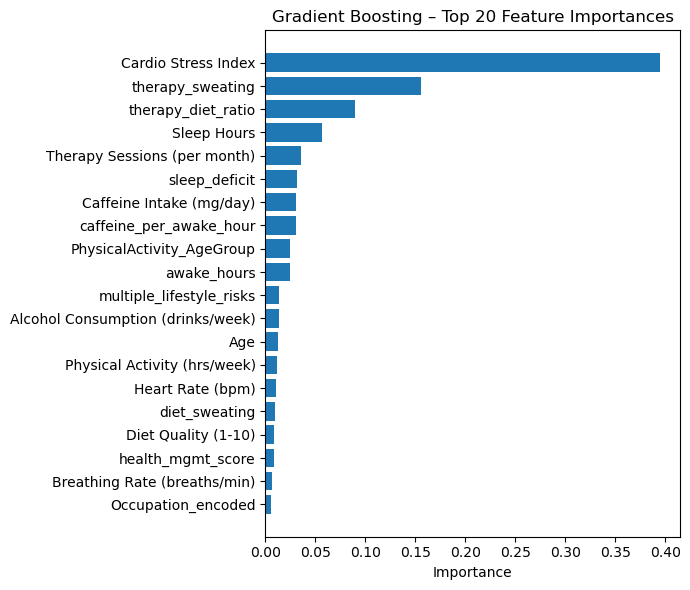

Exception ignored in: <function ResourceTracker.__del__ at 0x106975c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x111ef9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106481c60>
Traceback (most recent call last

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor(random_state=42)

param_grid_gbr = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0]
}

gbr_grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid_gbr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gbr_grid.fit(X_train, y_train)
print("GBR Best Params:", gbr_grid.best_params_)
print("GBR Best CV RMSE:", -gbr_grid.best_score_)

gbr_best = gbr_grid.best_estimator_
y_pred_gbr = gbr_best.predict(X_test)
mse  = mean_squared_error(y_test, y_pred_gbr)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_gbr)

print("GBR Test RMSE:", rmse)
print("GBR Test R2  :", r2)

#feature importances
fi_gbr = pd.Series(gbr_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(7,6))
plt.barh(fi_gbr.index[::-1], fi_gbr.values[::-1])
plt.title('Gradient Boosting – Top 20 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
